In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/ha/anaconda3/envs/self/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('../data/SB/SBUX .csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)
x = data.iloc[:,:-1]
y = data.iloc[:,5:6]

In [3]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_train = x_ss[-253:-53,:]
x_test = x_ss[-53:,:]
y_train = y_ms[-253:-53,:]
y_test = y_ms[-53:,:]

print('Training Shape', x_train.shape,y_train.shape)
print('Testing Shape', x_test.shape,y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [4]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [5]:
x_train_tensors_f = torch.reshape(x_train_tensors,(x_train_tensors.shape[0],1,x_train_tensors.shape[1]))
x_test_tensors_f = torch.reshape(x_test_tensors,(x_test_tensors.shape[0],1,x_test_tensors.shape[1]))

In [6]:
class GRU(nn.Module):
    def __init__(self,num_classes,input_size,hidden_size,num_layers,seq_len):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len

        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        
        self.fc_1 = nn.Linear(hidden_size,128)
        self.fc = nn.Linear(128,num_classes)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
        output, (hn) = self.gru(x,(h_0))
        hn = hn.view(-1,self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out


In [7]:
num_epochs = 1000 
learning_rate = 0.0001 

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 1 
model = GRU(num_classes, input_size, hidden_size, num_layers, x_train_tensors_f.shape[1]) 

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [8]:
for epoch in range(num_epochs):
    outputs = model.forward(x_train_tensors_f) 
    optimizer.zero_grad()  
    loss = criterion(outputs, y_train_tensors)
    loss.backward() 
 
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.04934
Epoch: 100, loss: 0.00428
Epoch: 200, loss: 0.00337
Epoch: 300, loss: 0.00336
Epoch: 400, loss: 0.00335
Epoch: 500, loss: 0.00334
Epoch: 600, loss: 0.00334
Epoch: 700, loss: 0.00333
Epoch: 800, loss: 0.00332
Epoch: 900, loss: 0.00332


In [9]:
df_x_ss = ss.transform(data.iloc[-253:, :-1]) 
df_y_ms = ms.transform(data.iloc[-253:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

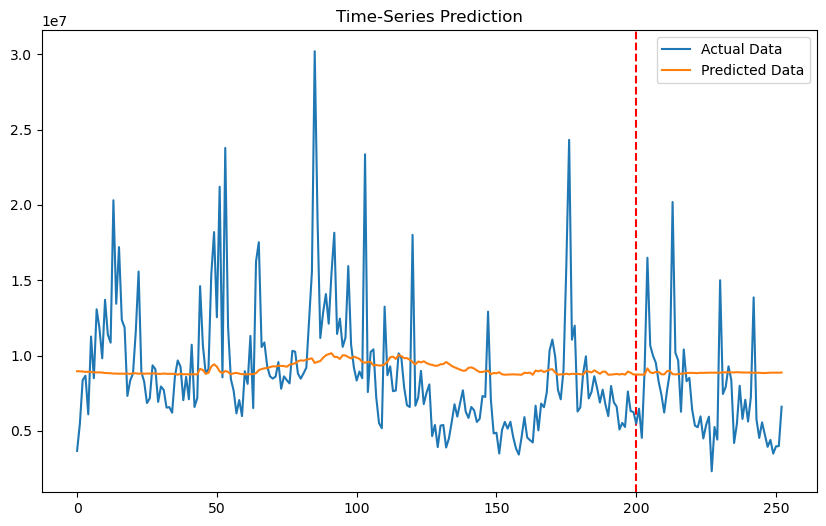

In [10]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 